### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 23rd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import corner
import colorcet as cc
from matplotlib import colormaps
import cmasher as cmr

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 

In [2]:
data = np.load('/Users/sofimar/vu_classes/astr_8070_s24/coursework/homeworks/hw_data/hw6_data_1.npy')

[Text(1, 0.4, '0'),
 Text(1, 1.2, '1'),
 Text(1, 2.0, '2'),
 Text(1, 2.8, '3'),
 Text(1, 3.6, '4')]

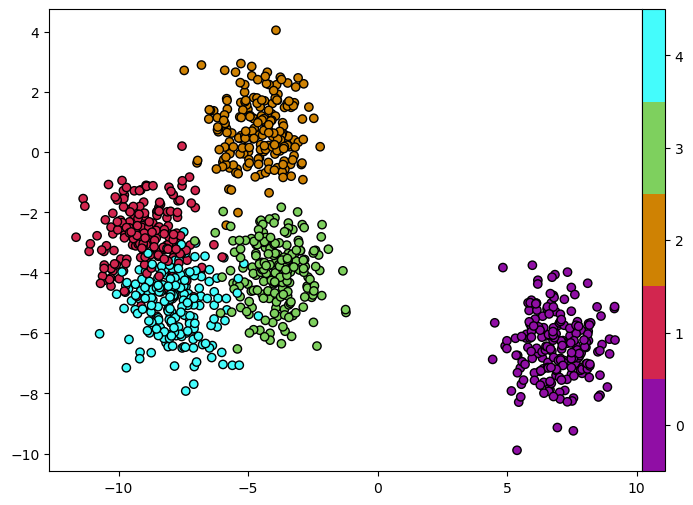

In [3]:
x = data[:,0]
y = data[:,1]
labels = data[:,2]

cm = cmr.get_sub_cmap('cmr.tropical', 0.0, 1.0, N=5)

plt.figure(figsize=(9,6))
plt.scatter(x, y, c=labels, cmap=cm, ec='k')
cbar = plt.colorbar(ticks=[0.1*4,0.3*4,0.5*4,0.7*4,0.9*4], pad=0)
cbar.ax.set_yticklabels(['0', '1', '2', '3', '4'])

2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 

In [4]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [5]:
bw = 30 # number of bandwidths
bw_min = 0.1
bw_max = 1

bw_range = np.linspace(bw_min, bw_max, bw)

grid = GridSearchCV(KernelDensity(), {'bandwidth': bw_range}, cv=5)
fit = grid.fit(data[:,0:-1])
# yfit = grid.fit(y[:,None])
bw_ = fit.best_params_['bandwidth']
# y_bw = yfit.best_params_['bandwidth']

print('Best Bandwidth: ', bw_)
# print('Best y Bandwidth: ', y_bw)

Best Bandwidth:  0.4724137931034482


In [6]:
u = v = np.linspace(-15,15,100)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T

In [7]:
X = np.array((x,y)).T

kde = KernelDensity(kernel='gaussian', bandwidth=bw_)
kde.fit(X)
dens = np.exp(kde.score_samples(Xgrid))

(-15.0, 15.0)

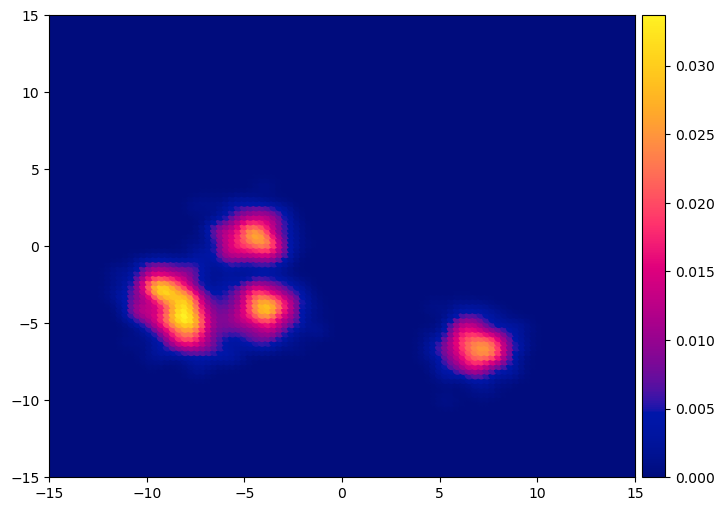

In [8]:
plt.figure(figsize=(9,6))
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, cmap=colormaps['cet_bmy'])
plt.colorbar(pad=0.01)
plt.xlim(-15,15)
plt.ylim(-15,15)

SRT: Nice. Great color scheme too. 

3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?

In [9]:
from astroML.density_estimation import KNeighborsDensity

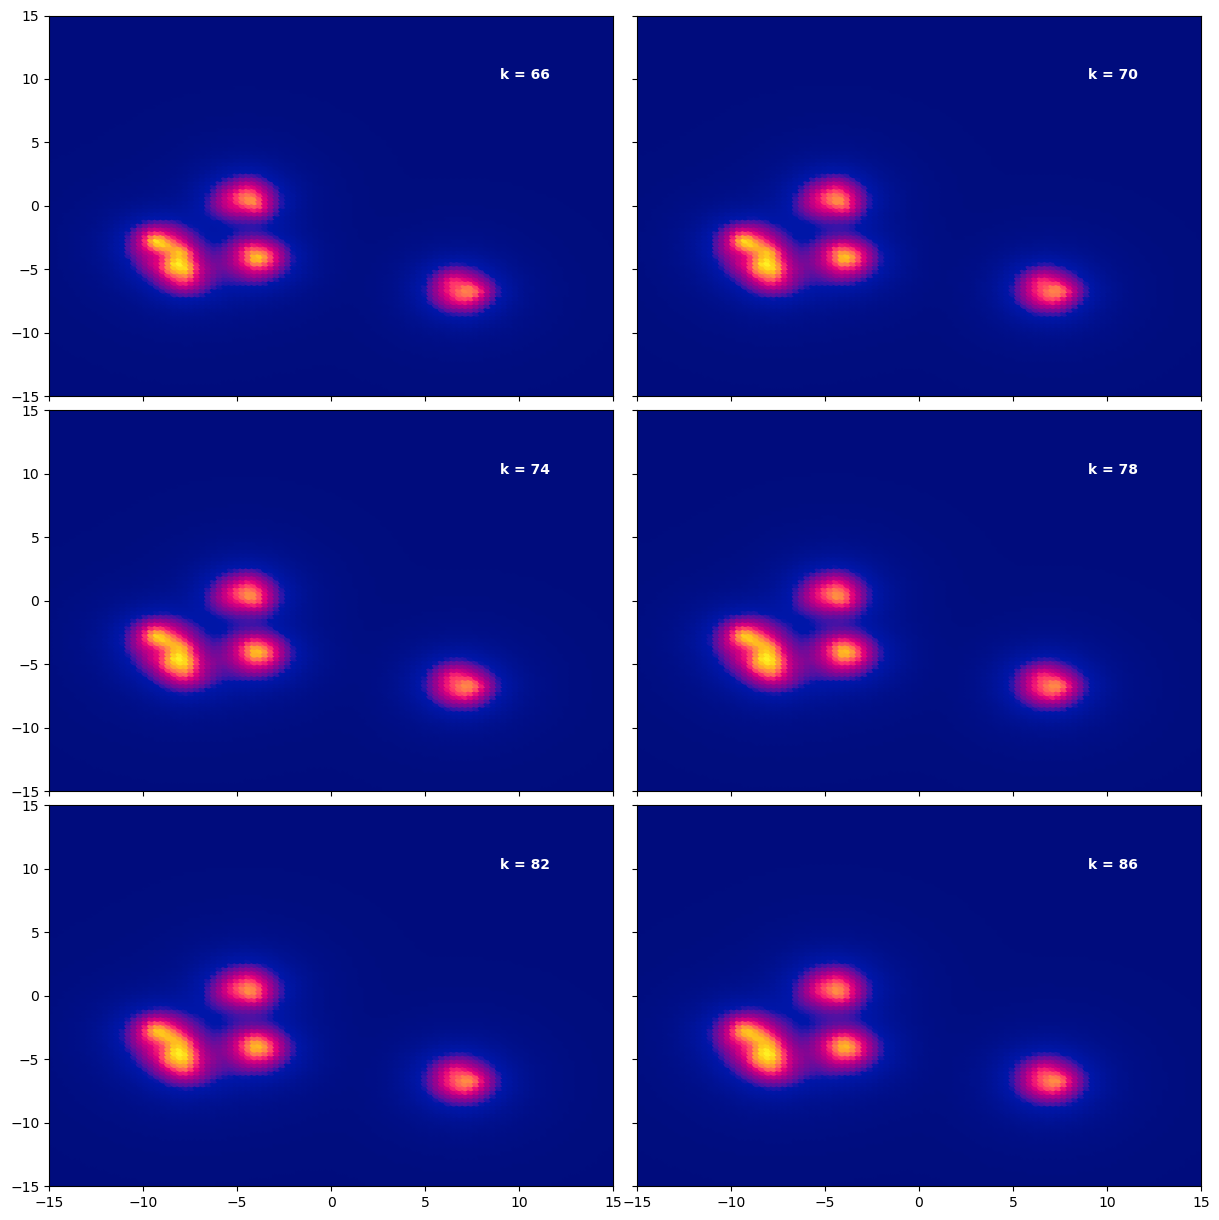

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(12,12))
ax = ax.flatten()
ks = [66, 70, 74, 78, 82, 86]


for i in range(6):
    nbr = KNeighborsDensity(method='bayesian', n_neighbors=ks[i])
    nbr.fit(X)
    dens_nbrs = nbr.eval(Xgrid)
    
    ax[i].set_xlim(-15,15)
    ax[i].set_ylim(-15,15)
    ax[i].scatter(Xgrid[:,0], Xgrid[:,1], c=dens_nbrs, cmap=colormaps['cet_bmy'])
    ax[i].text(9,10, 'k = '+str(ks[i]), color='white', weight='bold')
    

plt.tight_layout(pad=0)

#### I need about k = 66 neighbors

SRT: Awesome. Excellent visualization of this.

4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [11]:
from sklearn.mixture import GaussianMixture

In [12]:
n_comp = np.linspace(1,10,10)
models = np.empty(10)
aic = np.empty(10)
bic = np.empty(10)

for i in range(len(models)):
    N = int(n_comp[i])
    model = GaussianMixture(N).fit(X)
    aic[i] = model.aic(X)
    bic[i] = model.bic(X)

Text(0.5, 0, 'Number of Components')

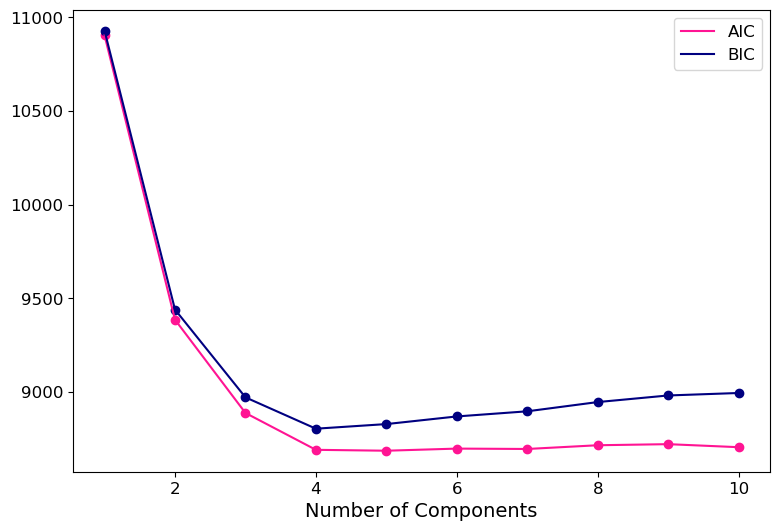

In [13]:
plt.figure(figsize=(9,6))

plt.plot(n_comp, aic, color='deeppink', label='AIC')
plt.scatter(n_comp, aic, color='deeppink')
plt.plot(n_comp, bic, color='navy', label='BIC')
plt.scatter(n_comp, bic, color='navy')
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Number of Components', fontsize=14)

#### The optimal number of components according to the BIC is 4

In [14]:
gmm = GaussianMixture(4)
gmm_fit = gmm.fit(X)
gmm_d = np.exp(gmm_fit.score_samples(Xgrid))

In [15]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    C00 = mu[0]-C[0][0] #first point, x
    C11 = C[1][1]-mu[1] #second point, y
    C01 = mu[1]-C[0][1] #first point,y
    sigma_x2 = C00
    sigma_y2 = C11
    sigma_xy = C01

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

**I'm gonna be honest, I cannot figure out for the life of me what the C variable is. Like yes, I know C[0,0] = bottom left, C[1,1] = top right, and C[0,1]= top left so that height = C[0,1] - C[0,0] and width = C[1,1] - C[0,1] but I have no clue what I would set C equal to when calling the function since everything I've tried gives me an error. I'm pretty sure C = [(x1,y1),(x2,y2)] or at least that is the idea so I changed the code above to do that. Ok update, now I get negative temp values which give me an error. I don't think the ellipses are happening tonight**

SRT: Oh, `C` is just the covariance matrix of the two-dimensional Gaussian. -2 points. Try this.

In [ ]:
ncomp_opt = N[np.argmin(BIC)]
gmm = GaussianMixture(n_components=ncomp_opt) ####
gmm.fit(X)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(X[:,0],X[:,1])

ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='s', c='red', s=80)
for mu, C in zip(gmm.means_, gmm.covariances_):
    draw_ellipse(mu, 1*C, scales=[2], ax=ax, fc='none', ec='k') #2 sigma ellipses for each component

(-15.0, 15.0)

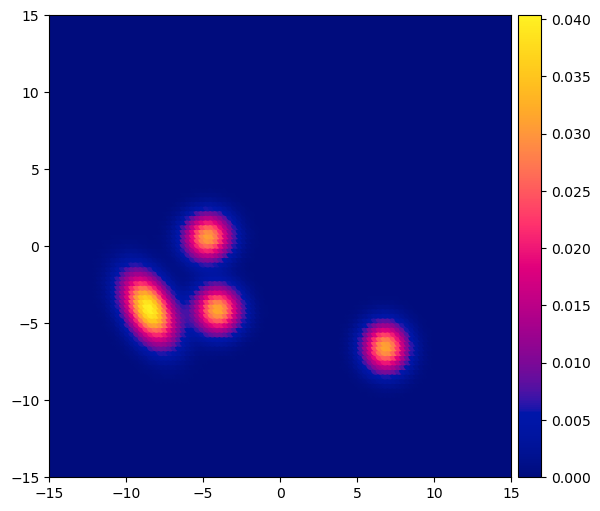

In [16]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set_aspect('equal')
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=gmm_d, cmap=colormaps['cet_bmy'])
plt.colorbar(pad=0.01)
plt.xlim(-15,15)
plt.ylim(-15,15)

# plt.scatter(-8,-2.5)
# draw_ellipse([-8,-4], [-11,-8])

In [17]:
C1 = [[-9,-5.6],[-8,-2.5]] # This was my test C for when I was trying to draw the ellipses

In [18]:
c1 = Xgrid[:,0] < -6 
c2 = Xgrid[:,0] > 5
c3 = Xgrid[:,1] > -2
# c4x = Xgrid[:,0] > -5
# c4x = Xgrid[:,0] < -1
# c4y = Xgrid[:,1] > -7
# c4y = Xgrid[:,1] < -2

(-5.5, -3.5)

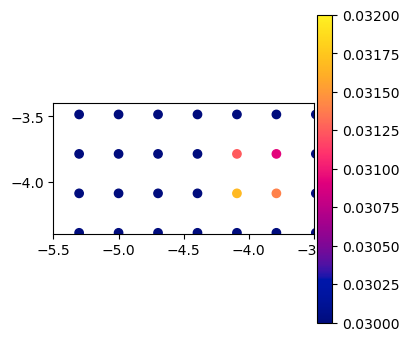

In [19]:
fig, ax = plt.subplots(figsize=(4,4))
ax.set_aspect('equal')
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=gmm_d, cmap=colormaps['cet_bmy'])
plt.colorbar(pad=0.01)
plt.clim(0.030, 0.032)
plt.ylim(-4.4,-3.4)
plt.xlim(-5.5,-3.5)


**Since there was no way to fully isolate one of the ellipses from the others using a single axis, I plotted and re-scaled a zoomed-in figure of the area around its center to estimate the coordinates of the maximum value by eye**

In [20]:
max1 = np.max(gmm_d[c1])
max2 = np.max(gmm_d[c2])
max3 = np.max(gmm_d[c3])

In [21]:
mu1 = [Xgrid[np.where(gmm_d==max1),0], Xgrid[np.where(gmm_d==max1),1]]
mu2 = [Xgrid[np.where(gmm_d==max2),0], Xgrid[np.where(gmm_d==max2),1]]
mu3 = [Xgrid[np.where(gmm_d==max3),0], Xgrid[np.where(gmm_d==max3),1]]
mu4 = [-4.1, -4.1]

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [60]:
# Define scaler
scaler = StandardScaler()

# Project and reduce
pca = PCA(n_components=2) # 2 components
pca.fit(X)
X_reduced = pca.transform(X)

# Fit Kmeans model
km = KMeans(n_clusters=5)
km.fit(scaler.fit_transform(X))

# Find cluster centers
centers = km.cluster_centers_
# inverse transform back to the original unscaled coordinates
inv_c = scaler.inverse_transform(centers)


# Predict Labels
labels2 = km.predict(X_reduced)

/Users/sofimar/opt/anaconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


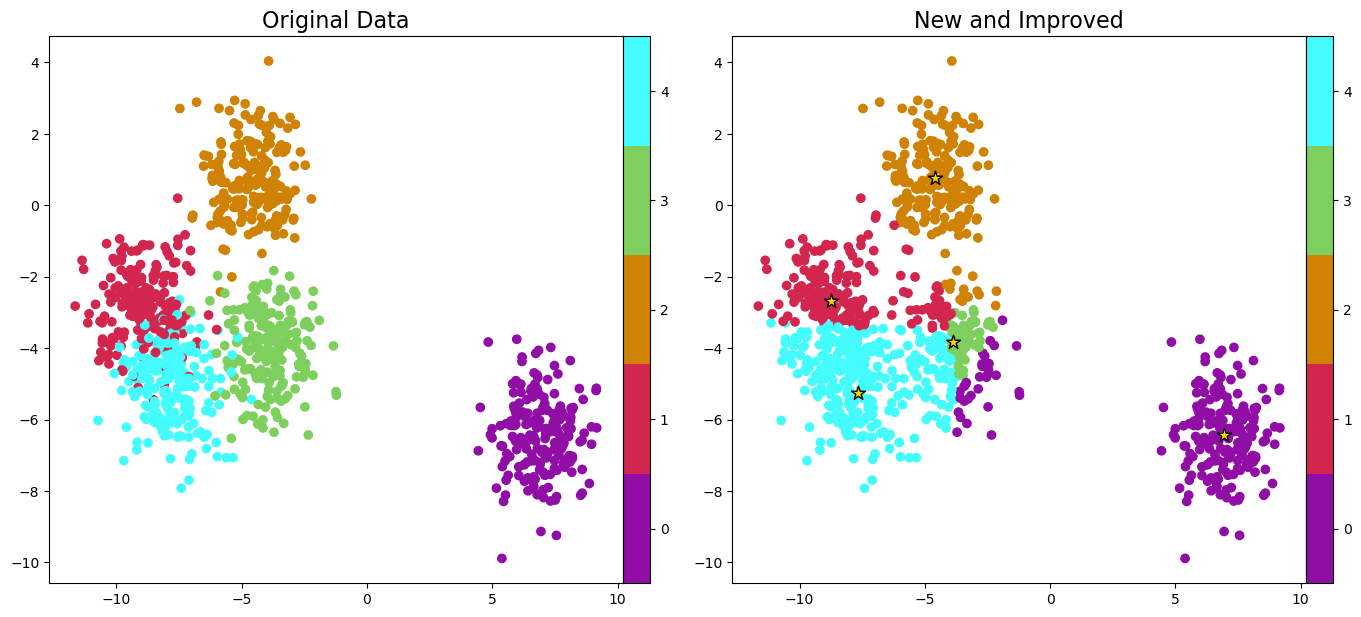

In [65]:
fig = plt.figure(figsize=(14,6))

fig.add_subplot(1,2,1)
plt.title('Original Data', fontsize=16)
plt.scatter(x, y, c=labels, cmap=cm)
cbar = plt.colorbar(ticks=[0.1*4,0.3*4,0.5*4,0.7*4,0.9*4], pad=0)
cbar.ax.set_yticklabels(['0', '1', '2', '3', '4'])

fig.add_subplot(1,2,2)
plt.title('New and Improved', fontsize=16)
plt.scatter(x, y, c=labels2, cmap=cm)
cbar2 = plt.colorbar(ticks=[0.1*4,0.3*4,0.5*4,0.7*4,0.9*4], pad=0)
plt.clim(0,4)
cbar2.ax.set_yticklabels(['0', '1', '2', '3', '4'])
plt.scatter(inv_c[:,0],inv_c[:,1], color='gold', ec='k', marker='*', s=111)

plt.tight_layout(pad=0.1)

SRT: There's an odd step in here. Why did you do a PCA first? Technically that means you needed to project the data back from it's PCA-transformed version at the very end (just like the step doing the inverse of the scalar transform), but I won't add a penalty. It's a good solution, and solves the problem very well!